In [19]:
import math
import matplotlib
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import time
import pandas_datareader.data as web

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline


test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

# Funciones Generales

In [3]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['adj_close'])):
        X_train = np.array(range(len(df['adj_close'][i-N:i]))) 
        y_train = np.array(df['adj_close'][i-N:i]) 
        X_train = X_train.reshape(-1, 1)     
              
        y_train = y_train.reshape(-1, 1)
        regr.fit(X_train, y_train)            
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list


def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [4]:
# Cargamos 10 años de Tata Consulting Services
df = yf.download('TCS.NS', 
                       start='2010-01-01', 
                       end='2020-03-31',
                       progress=False)
df['date']=df.index

df=df.reset_index(drop=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,date
0,377.399994,379.450012,374.524994,375.825012,284.856384,1963682,2010-01-04
1,377.500000,379.774994,373.274994,375.924988,284.932037,2014488,2010-01-05
2,375.924988,376.100006,366.500000,367.424988,278.489532,3349176,2010-01-06
3,367.750000,369.700012,355.500000,357.200012,270.739441,6474892,2010-01-07
4,358.000000,359.250000,348.250000,349.899994,265.206421,6048178,2010-01-08


In [5]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'date'], dtype='object')

# Cargamos Datos

In [6]:
# quitamos espacios de los nombres y ponemos formatos
# Convert Date column to datetime
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,open,high,low,close,adj_close,volume,date,month
0,377.399994,379.450012,374.524994,375.825012,284.856384,1963682,2010-01-04,1
1,377.500000,379.774994,373.274994,375.924988,284.932037,2014488,2010-01-05,1
2,375.924988,376.100006,366.500000,367.424988,278.489532,3349176,2010-01-06,1
3,367.750000,369.700012,355.500000,357.200012,270.739441,6474892,2010-01-07,1
4,358.000000,359.250000,348.250000,349.899994,265.206421,6048178,2010-01-08,1
5,352.000000,360.049988,350.200012,357.100006,270.663696,4318408,2010-01-11,1
6,366.000000,377.000000,363.500000,375.024994,284.250000,9027690,2010-01-12,1
7,372.500000,398.200012,372.325012,394.274994,298.840485,10910272,2010-01-13,1
8,399.225006,399.225006,384.674988,389.924988,295.543243,10327614,2010-01-14,1
9,398.000000,399.799988,386.125000,395.700012,299.920441,7945008,2010-01-15,1


Text(0, 0.5, 'USD')

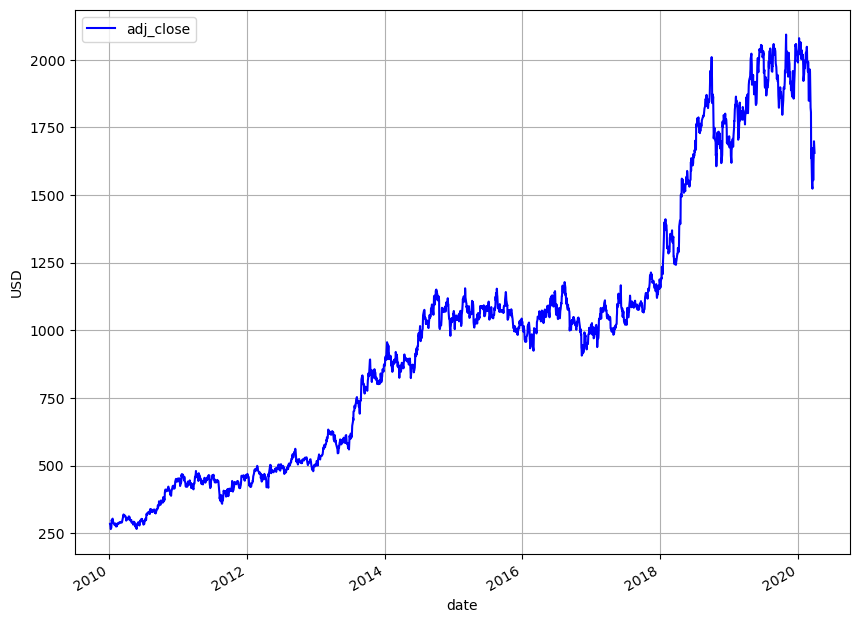

In [7]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Dividimos en train, dev and test set

In [8]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1516
num_cv = 504
num_test = 504
train.shape = (1516, 8)
cv.shape = (504, 8)
train_cv.shape = (2020, 8)
test.shape = (504, 8)


# EDA

Text(0, 0.5, 'USD')

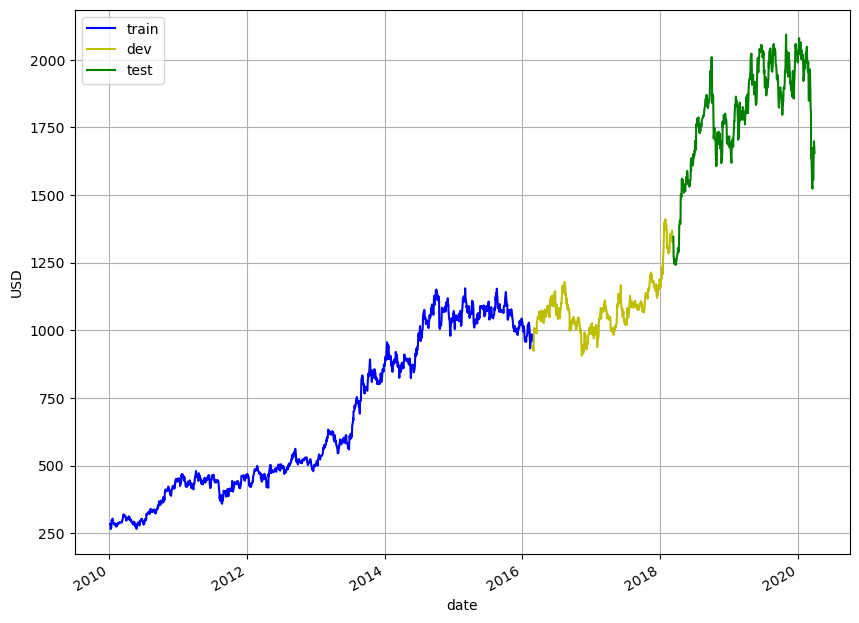

In [9]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict using Linear Regression

In [10]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    R2.append(r2_score(cv['adj_close'], est_list))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [15.25361908252458, 21.19642208131697, 18.971416298410645, 18.768791255149054, 19.24051358949373, 19.86637980237638, 20.652037614430384, 21.32697537959567, 21.883466782618438, 22.437059169251167, 23.065553601978763, 23.782951156334924, 24.386405319859346, 24.97357816745525, 25.577970454070794, 26.211674402820243, 26.851798896237042, 27.50051031642696, 28.199938397486466, 28.950036182870367, 29.6789249653112, 30.421823547712044, 31.16406985166923, 31.885291287888954, 32.53528627840635, 33.15436596981627, 33.78949991312342, 34.43342564637984, 35.13311190901698, 35.84404247236926]
R2 = [0.9731917271622094, 0.9482335767306127, 0.9585310967773107, 0.959412187129731, 0.9573463341689795, 0.9545262773053306, 0.9508584494159404, 0.9475939319726661, 0.9448233550596351, 0.9419964055272162, 0.9387013646189938, 0.9348289783885954, 0.9314798008226137, 0.9281404348976875, 0.9246201612971665, 0.9208387633221446, 0.9169251027250443, 0.9128626101069, 0.908373866500706, 0.9034346624775398, 0.89851

,open,high,low,close,adj_close,volume,date,month,est_N1,est_N2,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
1516,1131.224976,1131.224976,1100.599976,1105.474976,939.250916,1659328,2016-02-24,2,961.787781,939.739868,...,961.095928,964.439528,968.781516,971.664014,974.104139,976.205094,978.489117,979.863523,981.005239,980.610777
1517,1109.900024,1114.000000,1092.824951,1106.425049,940.058228,1830556,2016-02-25,2,939.250916,916.714050,...,951.258126,954.807765,958.178679,962.522276,965.486345,968.032084,970.253819,972.651795,974.172100,975.462484
1518,1114.849976,1128.449951,1099.800049,1105.250000,939.059814,1537536,2016-02-26,2,940.058228,940.865540,...,942.845339,946.183410,949.667253,953.004593,957.295249,960.283555,962.879898,965.170295,967.634329,969.253813
1519,1118.500000,1118.500000,1057.500000,1088.400024,924.743469,2191718,2016-02-29,2,939.059814,938.061401,...,935.423874,938.550485,941.773347,945.163650,948.438213,952.649658,955.631192,958.247103,960.575861,963.077809
1520,1096.500000,1142.550049,1081.000000,1138.324951,967.161499,1999760,2016-03-01,3,924.743469,910.427124,...,928.804307,929.422699,932.497800,935.686427,939.054651,942.328931,946.519410,949.542112,952.219976,954.625149


Text(0, 0.5, 'RMSE')

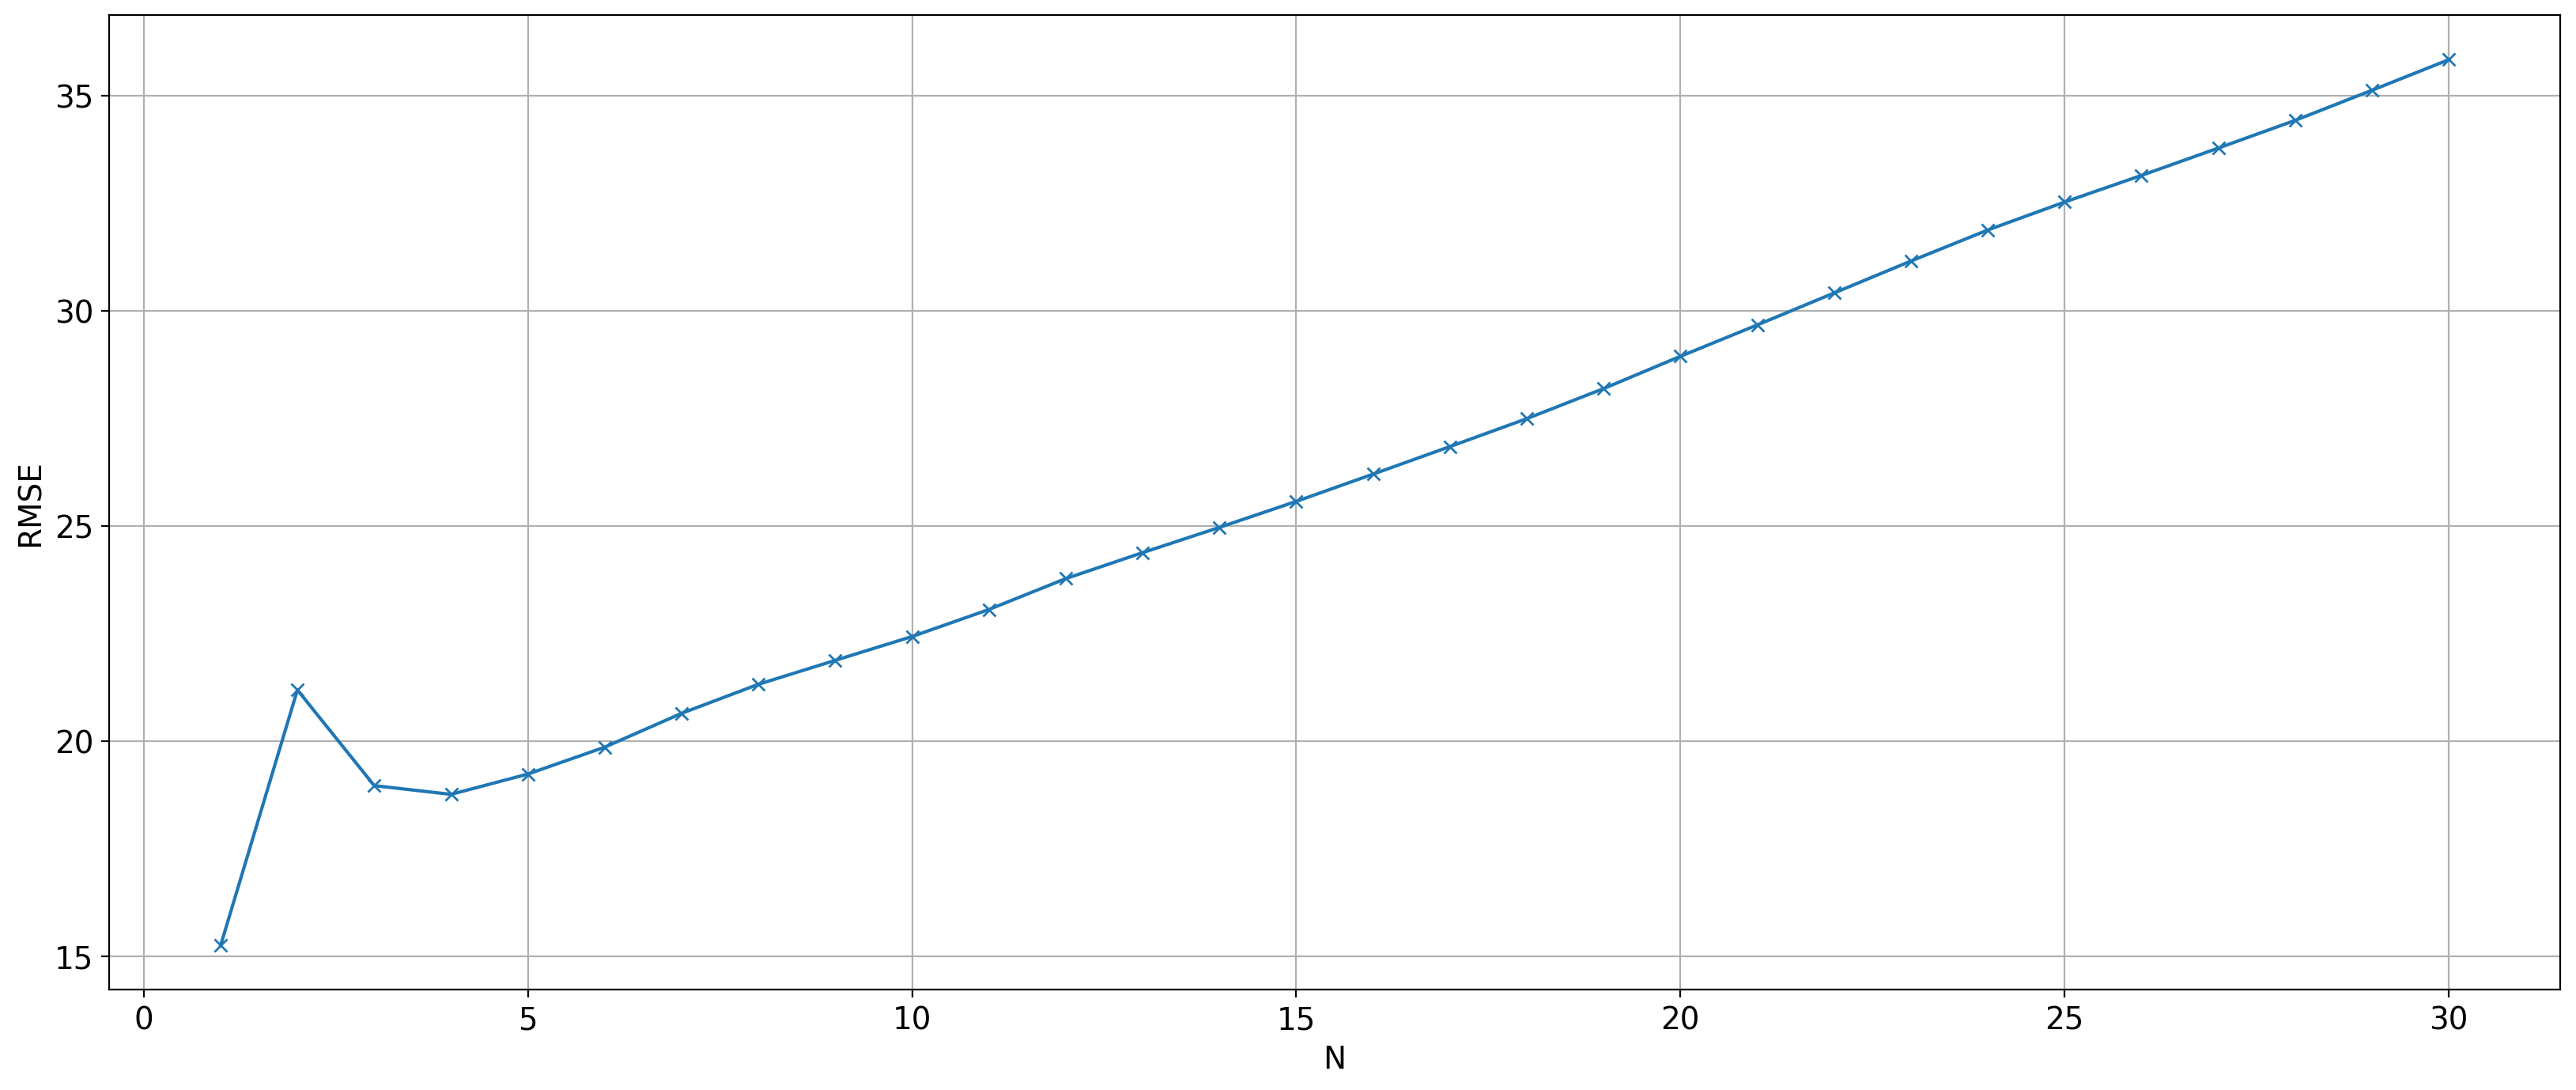

In [12]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20, 8), dpi=200)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')

Lowest RMSE is achieved with N=1, followed by N=5

Text(0, 0.5, 'R2')

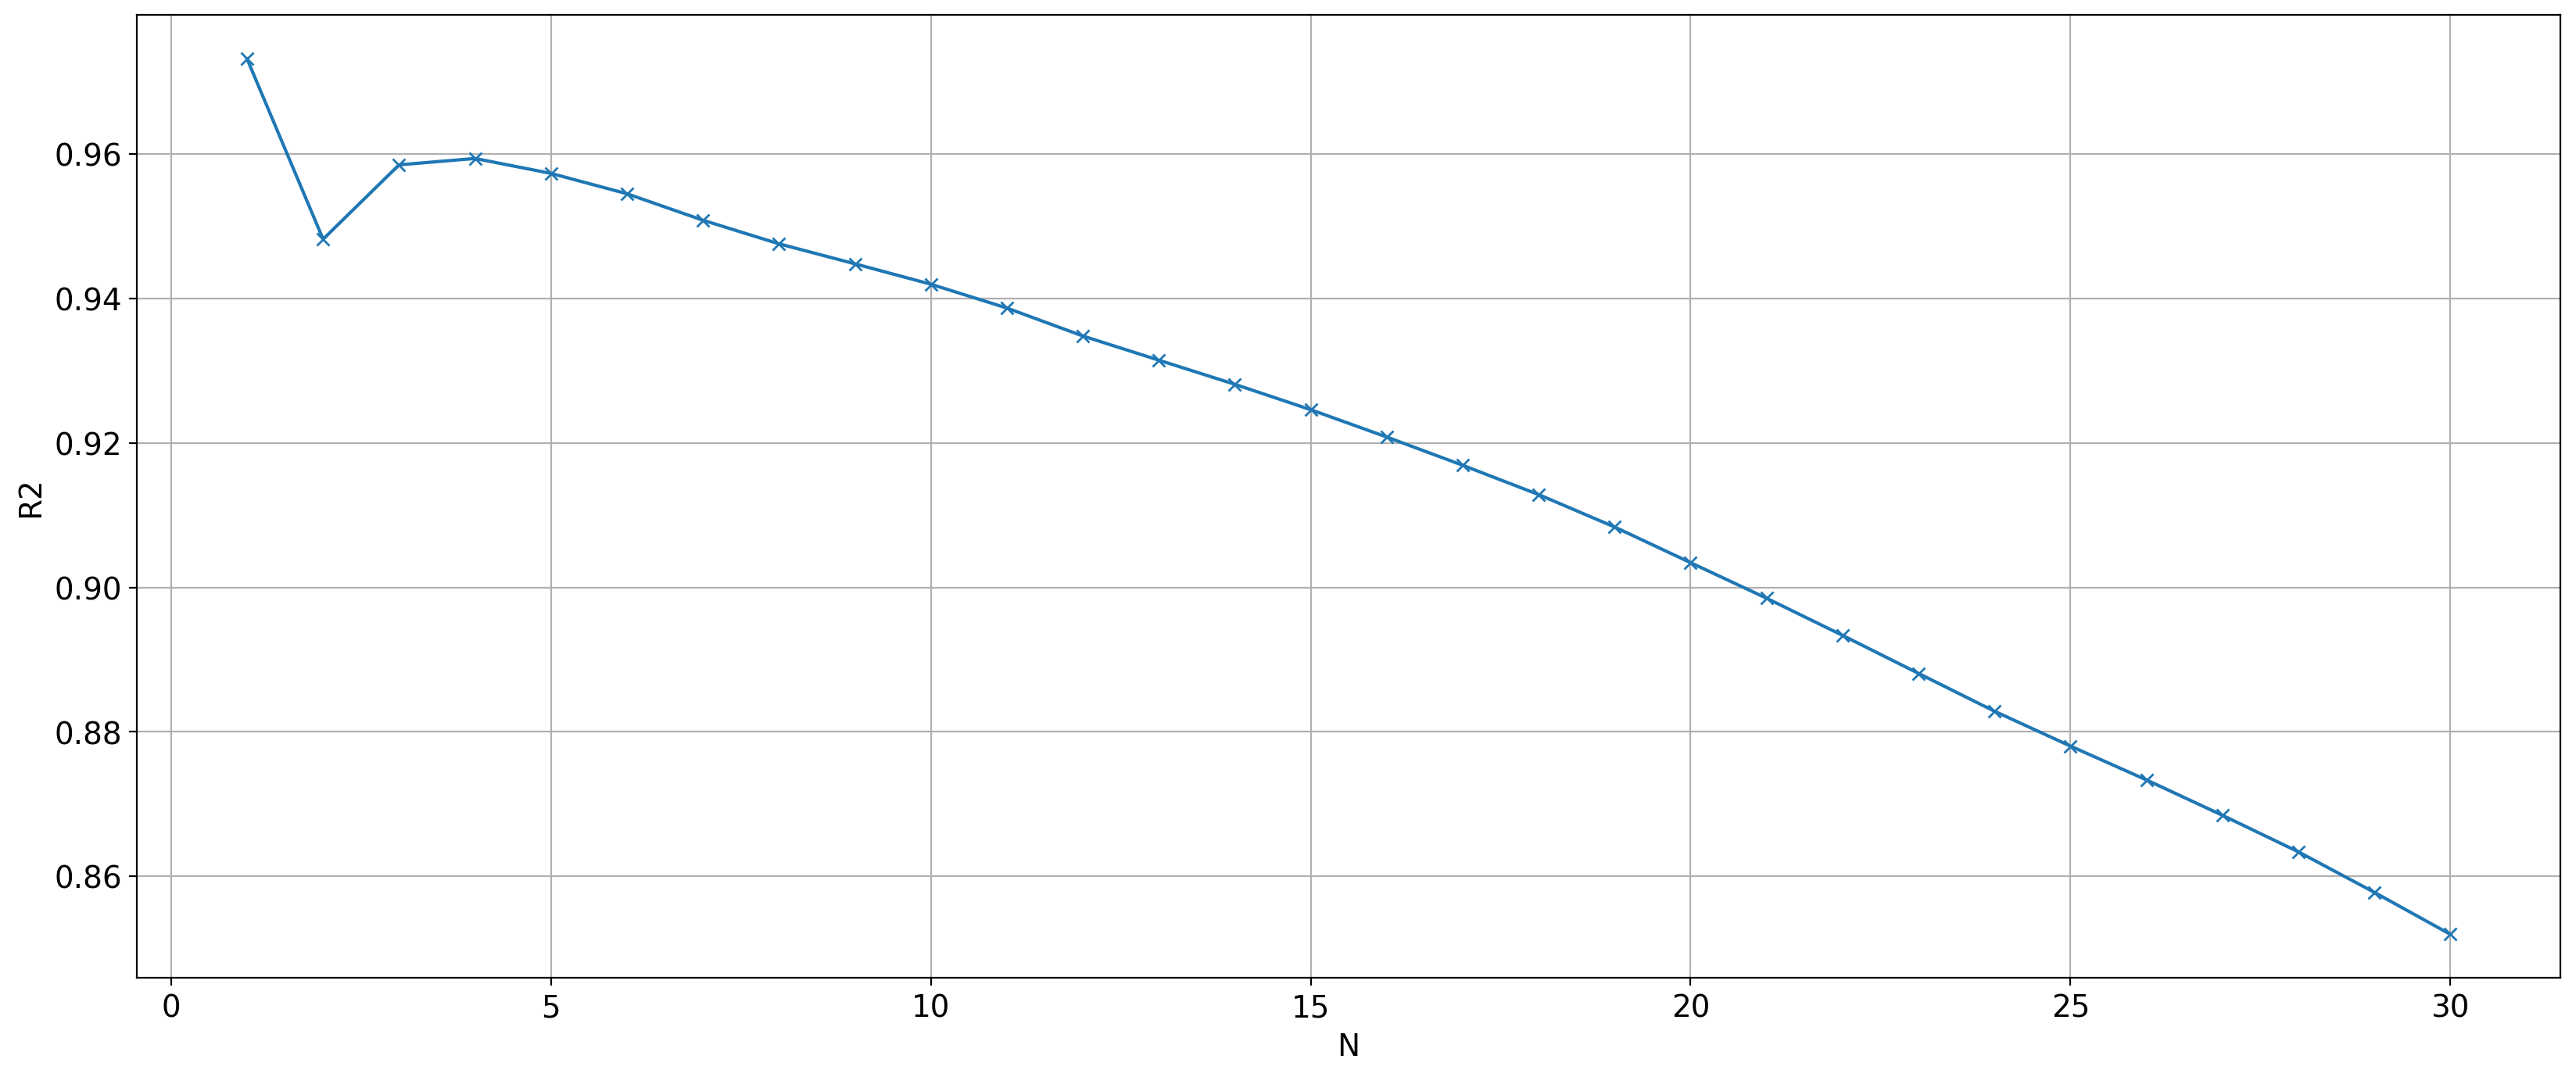

In [14]:
# Plot R2 versus N. Note for R2 larger better. 
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(20, 8), dpi=200)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

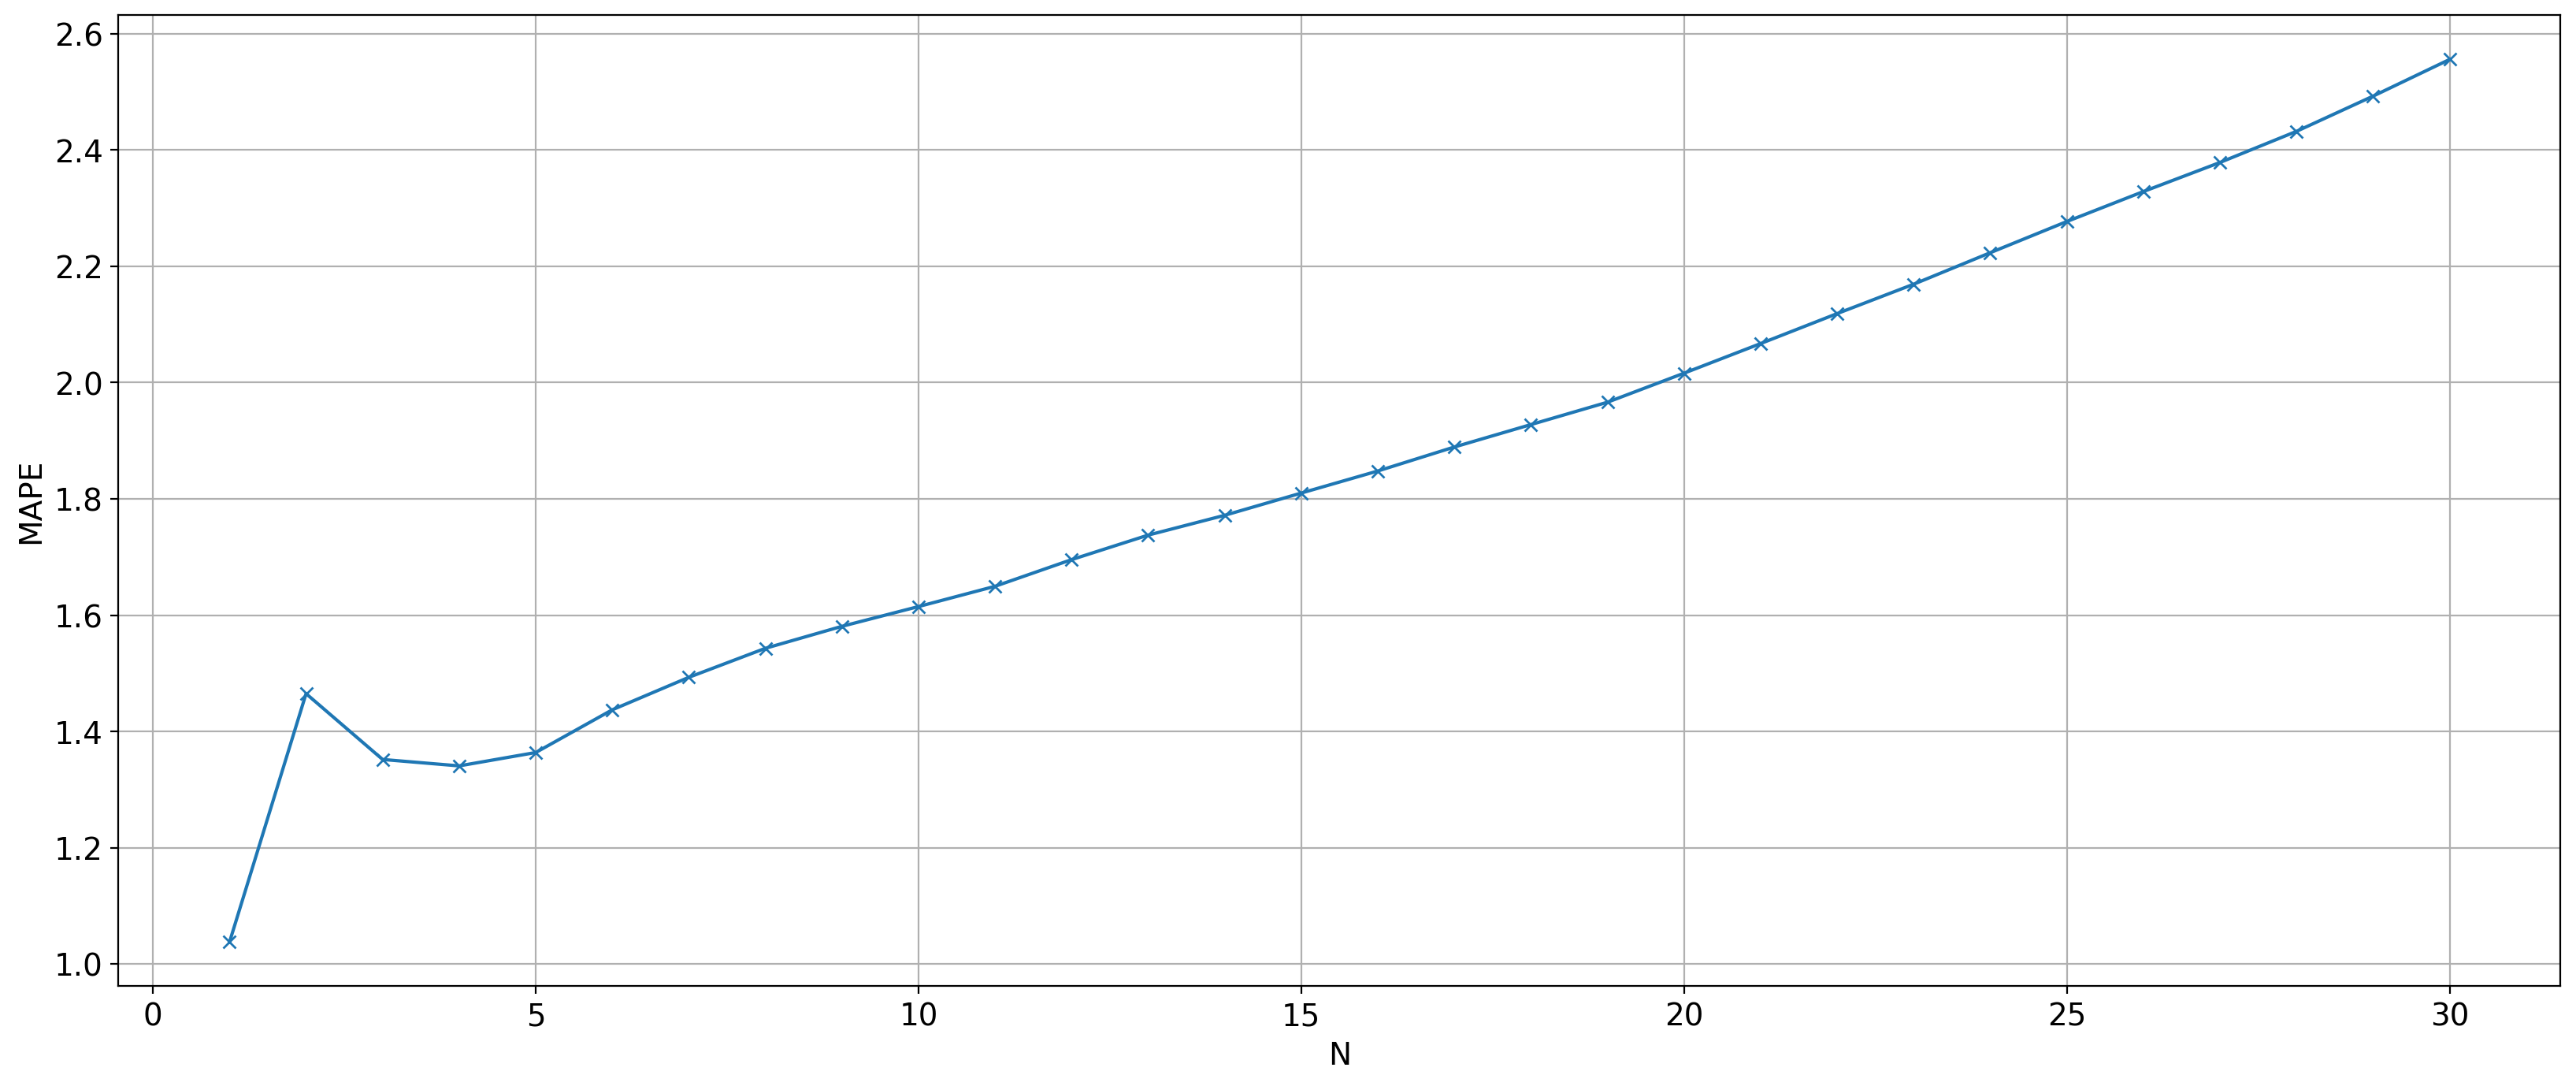

In [15]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(20, 8), dpi=200)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

# Plot predictions on dev set

Text(0, 0.5, 'USD')

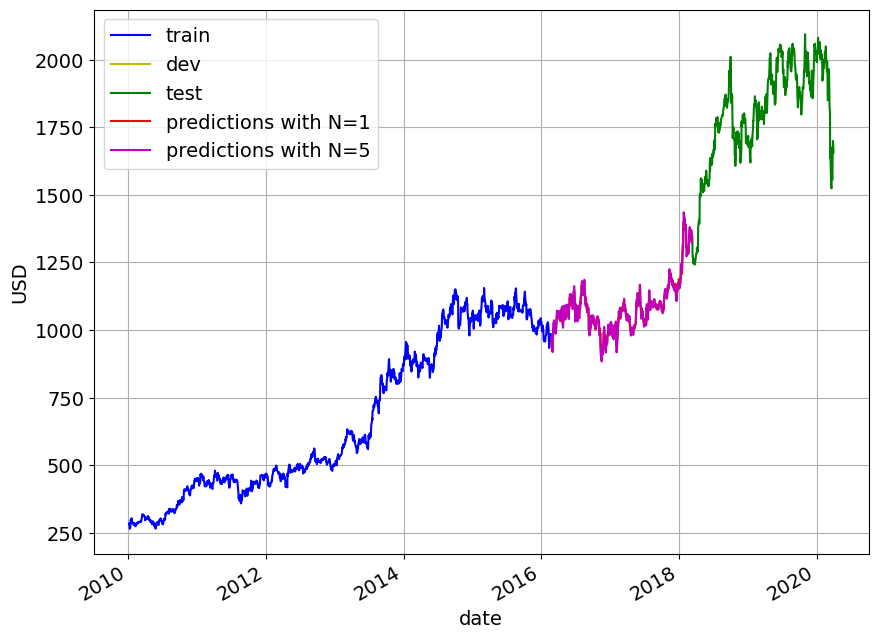

In [24]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

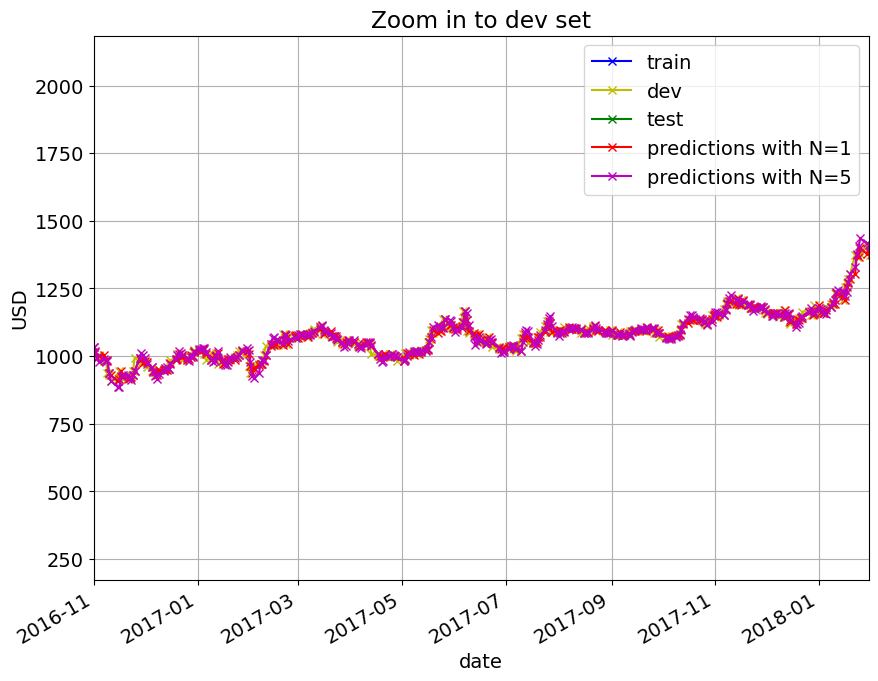

In [25]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2016, 11, 1), date(2018, 1, 30)])
#ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

# Final model

In [26]:
est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("R2 = %0.3f" % r2_score(test['adj_close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 38.310
R2 = 0.959
MAPE = 1.549%


,open,high,low,close,adj_close,volume,date,month,est_N5
2020,1521.500000,1541.949951,1517.750000,1526.074951,1346.094116,2091340,2018-03-12,3,1317.857166
2021,1462.449951,1469.849976,1436.000000,1443.400024,1273.169434,88067154,2018-03-13,3,1340.601123
2022,1446.474976,1461.525024,1437.525024,1443.449951,1273.213745,3668668,2018-03-14,3,1292.645386
2023,1447.500000,1451.275024,1427.800049,1434.849976,1265.628052,2348906,2018-03-15,3,1260.626563
2024,1434.400024,1436.000000,1402.500000,1412.849976,1246.222412,7197482,2018-03-16,3,1233.880371


Text(0, 0.5, 'USD')

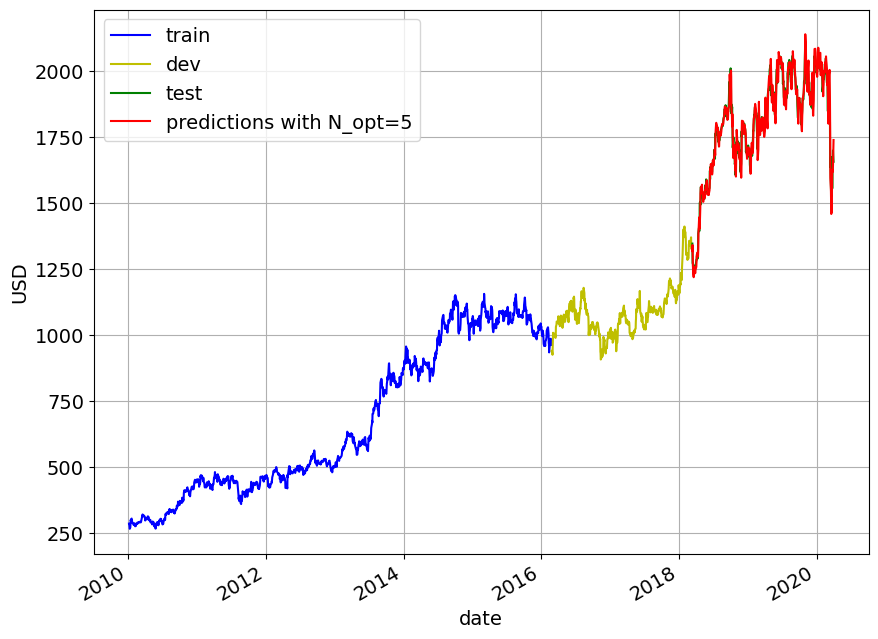

In [27]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

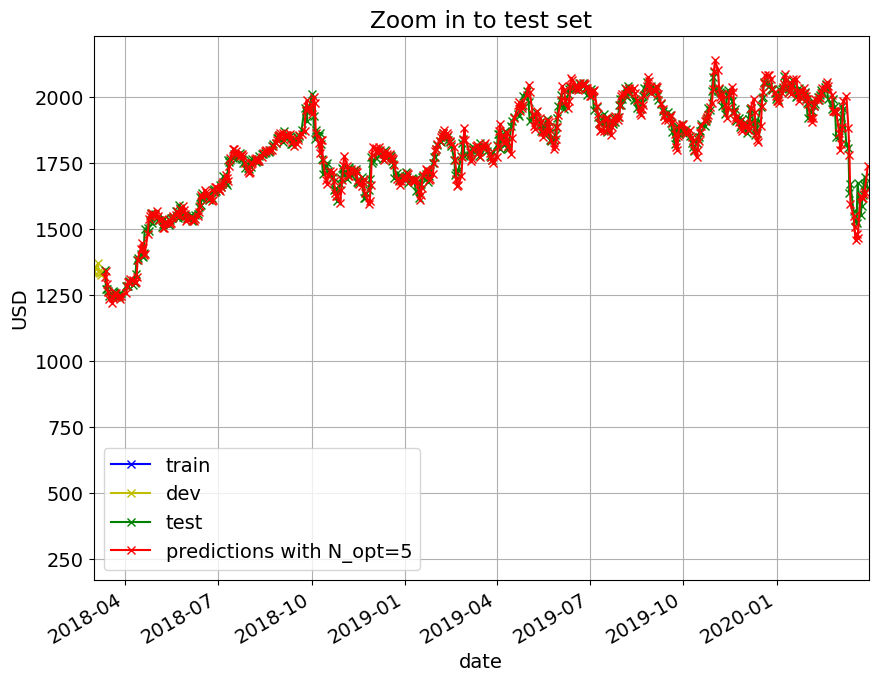

In [28]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018,3,1), date(2020, 3, 31)])
#ax.set_ylim([135, 150])
ax.set_title('Zoom in to test set')

(17613.0, 18352.0)

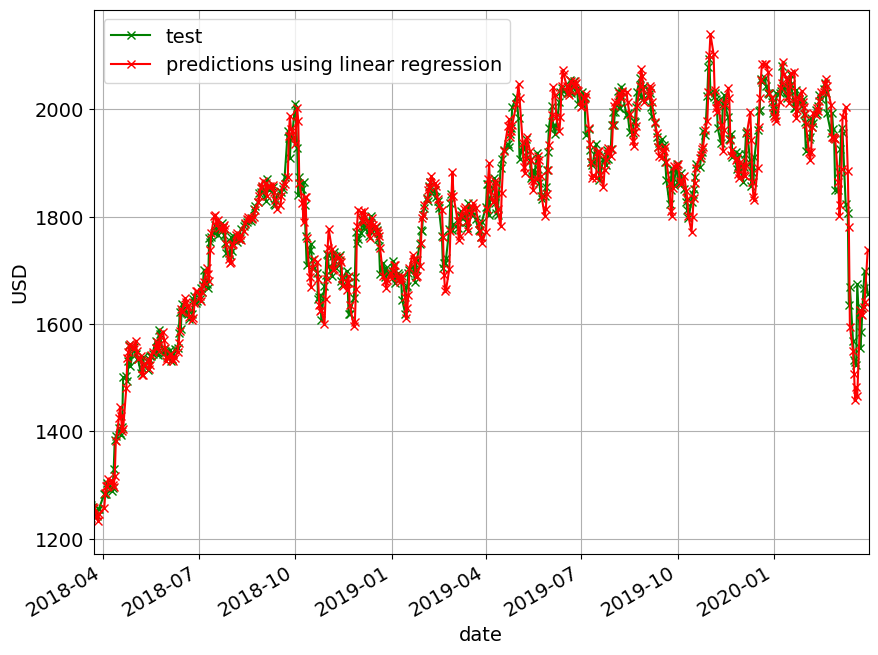

In [29]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N5', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 3, 23), date(2020, 3, 31)])
#ax.set_ylim([130, 155])

# MODEL2-XGBOOST REGRESSION

In [31]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/45/6d/8c1d2570a52db6263d855c3ee3daf8f4bdf4a365cd6610772d6fce5fd904/xgboost-2.0.3-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.3 MB/s eta 0:00:00a 0:00:01m


In [32]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web
import time

from datetime import *
from matplotlib import pyplot as plt

from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import *
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
%matplotlib inline



test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set
N = 3                                                              # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100                          # Number of boosted trees to fit. default = 100
max_depth = 3                               # Maximum tree depth for base learners. default = 3
learning_rate = 0.1                         # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1                     # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

# common functions

In [33]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() 
    std_list = df[col].rolling(window = N, min_periods=1).std()   
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

# Feature Engineering
We will generate the following features:

Mean 'adj_close' of each month, 
Difference between high and low of each day,
Difference between open and close of each day,
Mean volume of each month

In [35]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,adj_close,volume,date,month,range_hl,range_oc
0,284.856384,1963682,2010-01-04,1,4.925018,1.574982
1,284.932037,2014488,2010-01-05,1,6.500000,1.575012
2,278.489532,3349176,2010-01-06,1,9.600006,8.500000
3,270.739441,6474892,2010-01-07,1,14.200012,10.549988
4,265.206421,6048178,2010-01-08,1,11.000000,8.100006


In [36]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]
print(df.head())

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

    adj_close   volume       date  month   range_hl   range_oc  order_day
0  284.856384  1963682 2010-01-04      1   4.925018   1.574982          0
1  284.932037  2014488 2010-01-05      1   6.500000   1.575012          1
2  278.489532  3349176 2010-01-06      1   9.600006   8.500000          2
3  270.739441  6474892 2010-01-07      1  14.200012  10.549988          3
4  265.206421  6048178 2010-01-08      1  11.000000   8.100006          4


['adj_close', 'range_hl', 'range_oc', 'volume']

In [37]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
    
    
    
    
print(train_shift.head())
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

/var/folders/dh/3l29khbn1cq3dss6cwgvbkhw0000gn/T/ipykernel_12437/4263013851.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/3 [00:00<?, ?it/s]

   order_day  adj_close_lag_3  range_hl_lag_3  range_oc_lag_3  volume_lag_3
0          3       284.856384        4.925018        1.574982       1963682
1          4       284.932037        6.500000        1.575012       2014488
2          5       278.489532        9.600006        8.500000       3349176
3          6       270.739441       14.200012       10.549988       6474892
4          7       265.206421       11.000000        8.100006       6048178


,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,270.739441,6474892,2010-01-07,1,14.200012,10.549988,3,278.489532,9.600006,8.500000,3349176.0,284.932037,6.500000,1.575012,2014488.0,284.856384,4.925018,1.574982,1963682.0
4,265.206421,6048178,2010-01-08,1,11.000000,8.100006,4,270.739441,14.200012,10.549988,6474892.0,278.489532,9.600006,8.500000,3349176.0,284.932037,6.500000,1.575012,2014488.0
5,270.663696,4318408,2010-01-11,1,9.849976,-5.100006,5,265.206421,11.000000,8.100006,6048178.0,270.739441,14.200012,10.549988,6474892.0,278.489532,9.600006,8.500000,3349176.0
6,284.250000,9027690,2010-01-12,1,13.500000,-9.024994,6,270.663696,9.849976,-5.100006,4318408.0,265.206421,11.000000,8.100006,6048178.0,270.739441,14.200012,10.549988,6474892.0
7,298.840485,10910272,2010-01-13,1,25.875000,-21.774994,7,284.250000,13.500000,-9.024994,9027690.0,270.663696,9.849976,-5.100006,4318408.0,265.206421,11.000000,8.100006,6048178.0


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2521 entries, 3 to 2523
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   adj_close        2521 non-null   float64       
 1   volume           2521 non-null   int64         
 2   date             2521 non-null   datetime64[ns]
 3   month            2521 non-null   int64         
 4   range_hl         2521 non-null   float64       
 5   range_oc         2521 non-null   float64       
 6   order_day        2521 non-null   int64         
 7   adj_close_lag_1  2521 non-null   float64       
 8   range_hl_lag_1   2521 non-null   float64       
 9   range_oc_lag_1   2521 non-null   float64       
 10  volume_lag_1     2521 non-null   float64       
 11  adj_close_lag_2  2521 non-null   float64       
 12  range_hl_lag_2   2521 non-null   float64       
 13  range_oc_lag_2   2521 non-null   float64       
 14  volume_lag_2     2521 non-null   float64

In [39]:
# # Get mean of adj_close of each month
df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
df_gb

# # Merge to main df
df = df.merge(df_gb, 
               left_on=['month'], 
            right_on=['month'],
               how='left').fillna(0)
df.head()


,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean
0,270.739441,6474892,2010-01-07,1,14.200012,10.549988,3,278.489532,9.600006,8.500000,3349176.0,284.932037,6.500000,1.575012,2014488.0,284.856384,4.925018,1.574982,1963682.0,995.635117
1,265.206421,6048178,2010-01-08,1,11.000000,8.100006,4,270.739441,14.200012,10.549988,6474892.0,278.489532,9.600006,8.500000,3349176.0,284.932037,6.500000,1.575012,2014488.0,995.635117
2,270.663696,4318408,2010-01-11,1,9.849976,-5.100006,5,265.206421,11.000000,8.100006,6048178.0,270.739441,14.200012,10.549988,6474892.0,278.489532,9.600006,8.500000,3349176.0,995.635117
3,284.250000,9027690,2010-01-12,1,13.500000,-9.024994,6,270.663696,9.849976,-5.100006,4318408.0,265.206421,11.000000,8.100006,6048178.0,270.739441,14.200012,10.549988,6474892.0,995.635117
4,298.840485,10910272,2010-01-13,1,25.875000,-21.774994,7,284.250000,13.500000,-9.024994,9027690.0,270.663696,9.849976,-5.100006,4318408.0,265.206421,11.000000,8.100006,6048178.0,995.635117


In [40]:
# # Get mean of volume of each month
df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
df_gb = df_gb.rename(columns={'volume':'volume_mean'})
df_gb

# # Merge to main df
df = df.merge(df_gb, 
              left_on=['month'], 
               right_on=['month'],
               how='left').fillna(0)

df.head()

,adj_close,volume,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean
0,270.739441,6474892,2010-01-07,1,14.200012,10.549988,3,278.489532,9.600006,8.500000,...,284.932037,6.500000,1.575012,2014488.0,284.856384,4.925018,1.574982,1963682.0,995.635117,3.223537e+06
1,265.206421,6048178,2010-01-08,1,11.000000,8.100006,4,270.739441,14.200012,10.549988,...,278.489532,9.600006,8.500000,3349176.0,284.932037,6.500000,1.575012,2014488.0,995.635117,3.223537e+06
2,270.663696,4318408,2010-01-11,1,9.849976,-5.100006,5,265.206421,11.000000,8.100006,...,270.739441,14.200012,10.549988,6474892.0,278.489532,9.600006,8.500000,3349176.0,995.635117,3.223537e+06
3,284.250000,9027690,2010-01-12,1,13.500000,-9.024994,6,270.663696,9.849976,-5.100006,...,265.206421,11.000000,8.100006,6048178.0,270.739441,14.200012,10.549988,6474892.0,995.635117,3.223537e+06
4,298.840485,10910272,2010-01-13,1,25.875000,-21.774994,7,284.250000,13.500000,-9.024994,...,270.663696,9.849976,-5.100006,4318408.0,265.206421,11.000000,8.100006,6048178.0,995.635117,3.223537e+06


# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [41]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()
df.columns

Index(['adj_close', 'volume', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'volume_mean', 'adj_close_std',
       'range_hl_mean', 'range_hl_std', 'range_oc_mean', 'range_oc_std',
       'volume_std'],
      dtype='object')

# Split into train, dev and test set

In [34]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1513
num_cv = 504
num_test = 504
train.shape = (1513, 27)
cv.shape = (504, 27)
train_cv.shape = (2017, 27)
test.shape = (504, 27)


In [35]:
train.head()

,volume,adj_close,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_std
0,6474892.0,266.210876,2010-01-07,1,14.200012,10.549988,3,273.831268,9.600006,8.500000,...,1.574982,1963682.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6048178.0,260.770386,2010-01-08,1,11.000000,8.100006,4,266.210876,14.200012,10.549988,...,1.575012,2014488.0,266.210876,6.474892e+06,NaN,14.200012,NaN,10.549988,NaN,NaN
2,4318408.0,266.136444,2010-01-11,1,9.849976,-5.100006,5,260.770386,11.000000,8.100006,...,8.500000,3349176.0,263.490631,6.261535e+06,3.847008,12.600006,2.262750,9.324997,1.732399,3.017324e+05
3,9027690.0,279.495331,2010-01-12,1,13.500000,-9.024994,6,266.136444,9.849976,-5.100006,...,10.549988,6474892.0,264.372569,5.613826e+06,3.119804,11.683329,2.254087,4.516663,8.417888,1.141973e+06
4,10910272.0,293.841766,2010-01-13,1,25.875000,-21.774994,7,279.495331,13.500000,-9.024994,...,8.100006,6048178.0,268.800720,6.464759e+06,9.642597,11.449992,1.866156,-2.008331,8.971357,2.382119e+06


In [36]:
cv.head()

,volume,adj_close,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_std
1513,1659328.0,988.221252,2016-02-24,2,30.619995,25.750000,1516,1011.937378,31.569946,23.119995,...,-6.139893,879012.0,1027.959757,1.170249e+06,13.900938,20.449992,10.470531,6.383382,15.078111,252380.023974
1514,1830556.0,989.079346,2016-02-25,2,21.180054,3.469971,1517,988.221252,30.619995,25.750000,...,2.170044,1324884.0,1011.764587,1.430355e+06,23.457417,27.063314,6.999170,17.013346,12.921763,198501.583846
1515,1537536.0,988.024597,2016-02-26,2,28.649902,9.599976,1518,989.079346,21.180054,3.469971,...,23.119995,1306852.0,996.412659,1.598912e+06,13.451645,27.789998,5.744052,17.446655,12.175386,267028.162739
1516,2191718.0,972.961792,2016-02-29,2,61.000000,30.099976,1519,988.024597,28.649902,9.599976,...,25.750000,1659328.0,988.441732,1.675807e+06,0.560876,26.816650,4.979833,12.939982,11.509416,147203.396501
1517,1999760.0,1017.587341,2016-03-01,3,61.550049,-41.819946,1520,972.961792,61.000000,30.099976,...,3.469971,1830556.0,983.355245,1.853270e+06,9.016431,36.943319,21.165836,14.389974,13.946231,327681.959571


In [37]:
test.head()

,volume,adj_close,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_std
2017,2091340.0,1470.737183,2018-03-12,3,24.199951,-4.569946,2020,1462.044189,43.000000,-14.550049,...,21.280029,1917772.0,1456.129924,1.914011e+06,7.634875,37.316650,4.982571,10.736654,21.999384,3.982838e+04
2018,88067154.0,1391.064453,2018-03-13,3,33.849976,19.049927,2021,1470.737183,24.199951,-4.569946,...,25.479980,1951826.0,1460.097412,1.971867e+06,11.734902,33.633301,9.400202,2.119995,20.836682,1.108196e+05
2019,3668668.0,1391.112793,2018-03-14,3,24.000000,3.020020,2022,1391.064453,33.849976,19.049927,...,-14.550049,1872436.0,1441.281942,3.067698e+07,43.706283,33.683309,9.401133,-0.023356,17.255237,4.970147e+07
2020,2348906.0,1382.824585,2018-03-15,3,23.479980,12.650024,2023,1391.112793,24.000000,3.020020,...,-4.569946,2091340.0,1417.638143,3.127572e+07,45.985124,27.349976,5.630053,5.833333,12.058634,4.918915e+07
2021,7197482.0,1361.622314,2018-03-16,3,33.500000,21.550049,2024,1382.824585,23.479980,12.650024,...,19.049927,88067154.0,1388.333944,3.136158e+07,4.771306,27.109985,5.842791,11.573324,8.069011,4.911290e+07


In [38]:
train_cv.head()

,volume,adj_close,date,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,volume_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_std
0,6474892.0,266.210876,2010-01-07,1,14.200012,10.549988,3,273.831268,9.600006,8.500000,...,1.574982,1963682.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6048178.0,260.770386,2010-01-08,1,11.000000,8.100006,4,266.210876,14.200012,10.549988,...,1.575012,2014488.0,266.210876,6.474892e+06,NaN,14.200012,NaN,10.549988,NaN,NaN
2,4318408.0,266.136444,2010-01-11,1,9.849976,-5.100006,5,260.770386,11.000000,8.100006,...,8.500000,3349176.0,263.490631,6.261535e+06,3.847008,12.600006,2.262750,9.324997,1.732399,3.017324e+05
3,9027690.0,279.495331,2010-01-12,1,13.500000,-9.024994,6,266.136444,9.849976,-5.100006,...,10.549988,6474892.0,264.372569,5.613826e+06,3.119804,11.683329,2.254087,4.516663,8.417888,1.141973e+06
4,10910272.0,293.841766,2010-01-13,1,25.875000,-21.774994,7,279.495331,13.500000,-9.024994,...,8.100006,6048178.0,268.800720,6.464759e+06,9.642597,11.449992,1.866156,-2.008331,8.971357,2.382119e+06


# Scale the train, dev and test set

In [39]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [6.85153492e+02 6.84665649e+02 1.87936357e+01 4.04266055e-01
 2.79499012e+06 6.84166661e+02 1.87853739e+01 4.03872775e-01
 2.79544590e+06 6.83666519e+02 1.87815041e+01 4.08971833e-01
 2.79616280e+06]
scaler.var_ = [9.07548120e+04 9.07958154e+04 1.16920604e+02 1.59808684e+02
 2.83482685e+12 9.08225268e+04 1.17020397e+02 1.59807529e+02
 2.83380085e+12 9.08480015e+04 1.17104998e+02 1.59780108e+02
 2.83183015e+12]
train_scaled.shape = (1513, 13)
train_scaled.shape = (1513, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.390656,-1.363433,-0.850240,0.640407,0.329149,-1.340557,-1.135684,0.092642,-0.463920,-1.338957,-1.280458,0.092245,-0.494699,2010-01-07,1
1,-1.408715,-1.388723,-0.424825,0.802570,2.185612,-1.361577,-0.849114,0.640440,0.328938,-1.338710,-1.134916,0.092247,-0.464507,2010-01-08,1
2,-1.390903,-1.406778,-0.720766,0.608766,1.932172,-1.386863,-0.423880,0.802604,2.185736,-1.359727,-0.848449,0.640092,0.328626,2010-01-11,1
3,-1.346559,-1.388970,-0.827122,-0.435411,0.904807,-1.404916,-0.719695,0.608799,1.932251,-1.385009,-0.423369,0.802269,2.186071,2010-01-12,1
4,-1.298937,-1.344636,-0.489563,-0.745895,3.701800,-1.387110,-0.826006,-0.435382,0.904700,-1.403059,-0.719078,0.608448,1.932498,2010-01-13,1


In [40]:
# Do scaling for dev set
cv_scaled = cv[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

,date,adj_close,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
1513,2016-02-24,988.221252,-1.152611,0.516179,0.636432,1.062024,-0.138483,-0.923541,1.109994,-0.279434,-0.830560,0.541258,0.612706,-1.153963
1514,2016-02-25,989.079346,-1.003663,0.007366,0.996297,0.508158,0.643881,-1.152039,0.676119,0.472586,-1.148706,1.153509,-0.622175,-0.531334
1515,2016-02-26,988.024597,-0.545161,-0.608952,1.154113,-1.150746,0.492683,0.658063,-1.147946,0.681978,0.465968,0.867489,0.226253,-1.093742
1516,2016-02-29,972.961792,-0.743720,1.136818,-0.393098,0.368135,-1.131885,0.763750,-0.290198,-0.822806,1.113003,-0.939317,1.051262,-0.111945
1517,2016-03-01,1017.587341,-1.152724,0.517871,0.634852,1.136581,-0.391830,-0.744750,1.126469,-0.343462,-0.783007,1.032855,-0.963538,-0.069317


In [41]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [8.05443142e+02 8.04854043e+02 2.04855913e+01 1.80174329e-01
 2.65623465e+06 8.04275290e+02 2.04721060e+01 1.68322584e-01
 2.65626572e+06 8.03690886e+02 2.04570713e+01 1.58553101e-01
 2.65628848e+06]
scaler_train_cv.var_ = [1.14512528e+05 1.14438550e+05 1.33248687e+02 1.88031636e+02
 2.57397315e+12 1.14369941e+05 1.33258905e+02 1.87715117e+02
 2.57393133e+12 1.14293407e+05 1.33270244e+02 1.87495029e+02
 2.57389875e+12]
train_cv_scaled.shape = (2017, 13)
train_cv_scaled.shape = (2017, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.593490,-1.569737,-0.943019,0.606735,0.431911,-1.549765,-1.210358,0.102671,-0.400024,-1.548776,-1.345434,0.103443,-0.431709,2010-01-07,1
1,-1.609567,-1.592264,-0.544520,0.756233,2.380174,-1.568497,-0.941814,0.608111,0.431895,-1.548555,-1.209004,0.103445,-0.400041,2010-01-08,1
2,-1.593710,-1.608346,-0.821737,0.577565,2.114203,-1.591030,-0.543331,0.757735,2.380174,-1.567293,-0.940472,0.609181,0.431884,2010-01-11,1
3,-1.554233,-1.592484,-0.921364,-0.385064,1.036035,-1.607117,-0.820537,0.578916,2.114200,-1.589834,-0.542005,0.758893,2.380175,2010-01-12,1
4,-1.511838,-1.552994,-0.605162,-0.671299,3.971336,-1.591250,-0.920160,-0.384524,1.036024,-1.605926,-0.819200,0.579969,2.114200,2010-01-13,1


In [42]:
# Do scaling for test set
test_scaled = test[['date','adj_close']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

,date,adj_close,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
2017,2018-03-12,1470.737183,0.774638,-1.128906,0.354268,1.140646,-0.725870,-0.414776,-1.149428,0.670170,0.479258,-1.043862,0.949440,0.094422
2018,2018-03-13,1391.064453,0.906677,0.165896,-1.072574,-1.003526,0.996436,0.007090,-0.321066,-0.800034,1.121099,1.078083,-0.897236,-0.180846
2019,2018-03-14,1391.112793,-1.148976,0.673936,0.475040,0.017728,-1.008746,0.991018,1.105362,-0.263490,-0.841872,1.154698,-0.575147,-0.579551
2020,2018-03-15,1382.824585,-0.576825,-0.577876,1.154700,-0.595017,1.154518,-0.559502,-0.233303,1.096027,-0.862725,-0.561243,1.154552,-0.593309
2021,2018-03-16,1361.622314,-1.154686,0.582409,0.572277,-0.621279,-0.532277,1.153557,0.133437,-1.060019,0.926582,-0.590734,-0.563862,1.154596


In [43]:
train.columns

Index(['volume', 'adj_close', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'volume_mean', 'adj_close_std',
       'range_hl_mean', 'range_hl_std', 'range_oc_mean', 'range_oc_std',
       'volume_std'],
      dtype='object')

In [44]:
cv.columns

Index(['volume', 'adj_close', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'volume_mean', 'adj_close_std',
       'range_hl_mean', 'range_hl_std', 'range_oc_mean', 'range_oc_std',
       'volume_std'],
      dtype='object')

In [45]:
test.columns

Index(['volume', 'adj_close', 'date', 'month', 'range_hl', 'range_oc',
       'order_day', 'adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1',
       'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2',
       'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3',
       'volume_lag_3', 'adj_close_mean', 'volume_mean', 'adj_close_std',
       'range_hl_mean', 'range_hl_std', 'range_oc_mean', 'range_oc_std',
       'volume_std'],
      dtype='object')

# Split into X and y

In [46]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"
print(features)


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

['adj_close_lag_1', 'range_hl_lag_1', 'range_oc_lag_1', 'volume_lag_1', 'adj_close_lag_2', 'range_hl_lag_2', 'range_oc_lag_2', 'volume_lag_2', 'adj_close_lag_3', 'range_hl_lag_3', 'range_oc_lag_3', 'volume_lag_3']
X_train.shape = (1513, 12)
y_train.shape = (1513,)
X_cv.shape = (504, 12)
y_cv.shape = (504,)
X_train_cv.shape = (2017, 12)
y_train_cv.shape = (2017,)
X_sample.shape = (504, 12)
y_sample.shape = (504,)


In [47]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled['adj_close']
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled['adj_close']
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (1513, 12)
y_train_scaled.shape = (1513,)
X_cv_scaled.shape = (504, 12)
X_train_cv_scaled.shape = (2017, 12)
y_train_cv_scaled.shape = (2017,)
X_sample_scaled.shape = (504, 12)


# EDA

Text(0.5, 1.0, 'Without scaling')

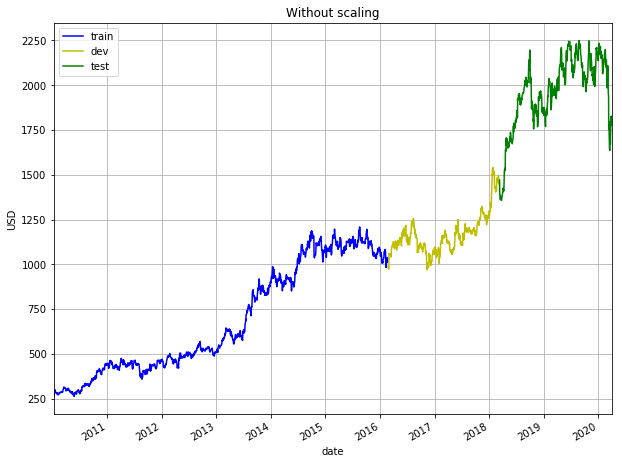

In [48]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

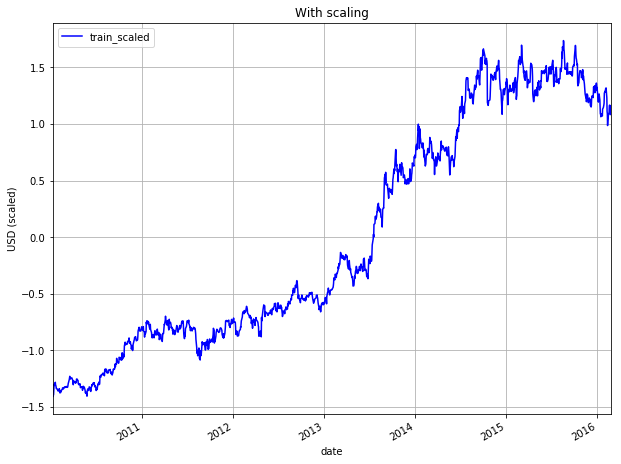

In [49]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

In [50]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=100, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

In [51]:
# Do prediction on train set

est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 8.777
MAPE on train set = 0.968%


Text(0.5, 1.0, 'Without scaling')

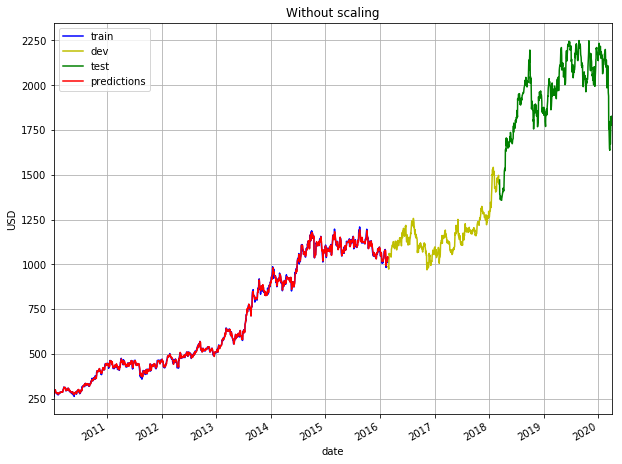

In [52]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

In [53]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


RMSE on dev set = 17.198
MAPE on dev set = 1.092%


Text(0, 0.5, 'USD')

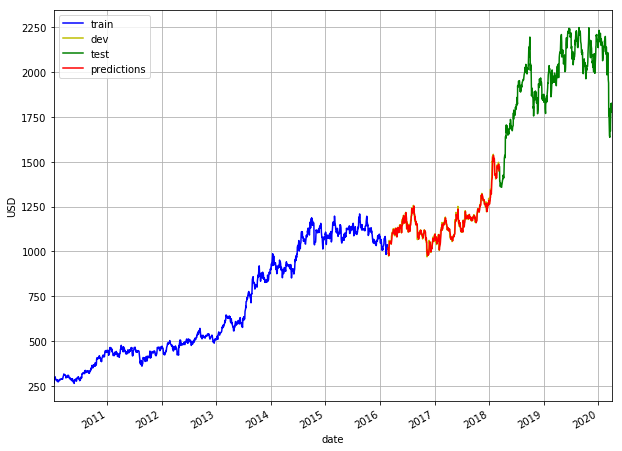

In [54]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

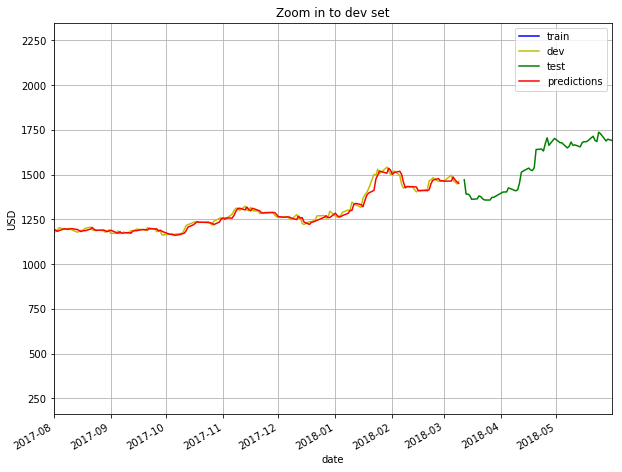

In [55]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 8, 1), date(2018, 5, 31)])
ax.set_title("Zoom in to dev set")

In [56]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]



[('range_hl_lag_3', 9.944523e-05),
 ('volume_lag_1', 0.000102662074),
 ('range_oc_lag_3', 0.00011057607),
 ('range_oc_lag_1', 0.00013521728),
 ('volume_lag_3', 0.00014531978),
 ('volume_lag_2', 0.00017170237),
 ('range_hl_lag_2', 0.0004182359),
 ('adj_close_lag_3', 0.06562511),
 ('adj_close_lag_1', 0.36561614),
 ('adj_close_lag_2', 0.5673777)]

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [57]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic =time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

,n_estimators,max_depth,rmse,mape_pct
0,10,2,17.831905,1.133132
1,10,3,18.431708,1.174970
2,10,4,18.647270,1.189536
3,10,5,17.451683,1.107801
4,10,6,17.437074,1.106787
5,10,7,17.439790,1.106782
6,10,8,17.440883,1.106860
7,10,9,17.441178,1.106795
8,20,2,17.102207,1.084201
9,20,3,17.453123,1.108014


In [58]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 16.671
optimum params = 


(60, 8)

In [59]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.056%
optimum params = 


(40, 8)

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [60]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,21.129647,1.357183
1,0.001,6,21.130020,1.357203
2,0.001,7,21.129807,1.357193
3,0.001,8,21.128832,1.357140
4,0.001,9,21.129802,1.357190
5,0.001,10,21.129098,1.357163
6,0.001,11,21.129968,1.357204
7,0.001,12,21.130967,1.357240
8,0.001,13,21.130955,1.357237
9,0.001,14,21.129682,1.357190


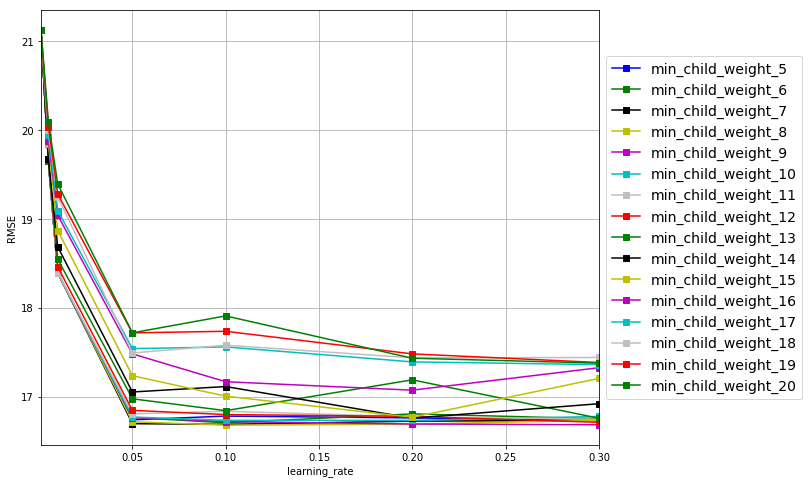

In [61]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [62]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 16.678
optimum params = 


(0.1, 8)

In [63]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.056%
optimum params = 


(0.3, 9)

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [64]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

,subsample,gamma,rmse,mape_pct
0,0.1,0.1,16.761448,1.058328
1,0.1,0.2,16.905926,1.066443
2,0.1,0.3,16.590281,1.046822
3,0.1,0.4,16.688963,1.052043
4,0.1,0.5,16.585918,1.048162
5,0.1,0.6,16.635739,1.050587
6,0.1,0.7,16.614231,1.048679
7,0.1,0.8,16.620011,1.049746
8,0.1,0.9,16.632168,1.050955
9,0.1,1.0,16.692271,1.053847


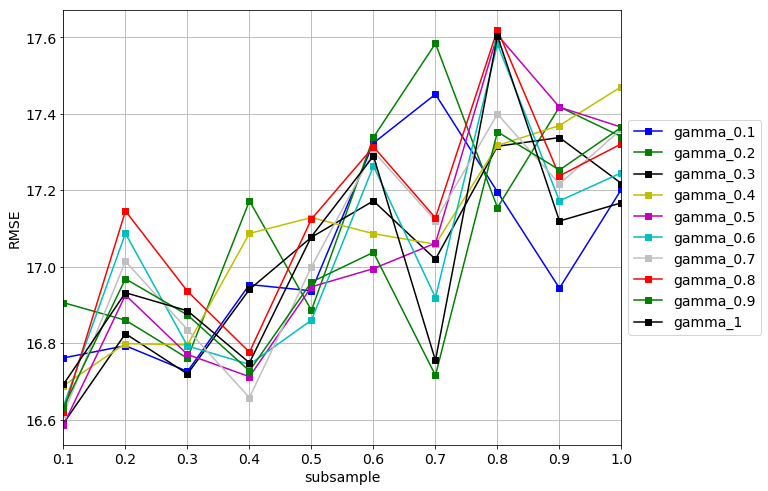

In [65]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [66]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 16.586
optimum params = 


(0.1, 0.5)

In [67]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.047%
optimum params = 


(0.1, 0.3)

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [68]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
#tic = time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
#toc = time()
#print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,22.517183,1.433417
1,0.5,0.6,22.517183,1.433417
2,0.5,0.7,21.896528,1.396753
3,0.5,0.8,21.896528,1.396753
4,0.5,0.9,21.726575,1.384592
5,0.5,1.0,21.429385,1.370211
6,0.6,0.5,21.681494,1.383547
7,0.6,0.6,21.139165,1.346224
8,0.6,0.7,21.139165,1.346224
9,0.6,0.8,21.346751,1.363043


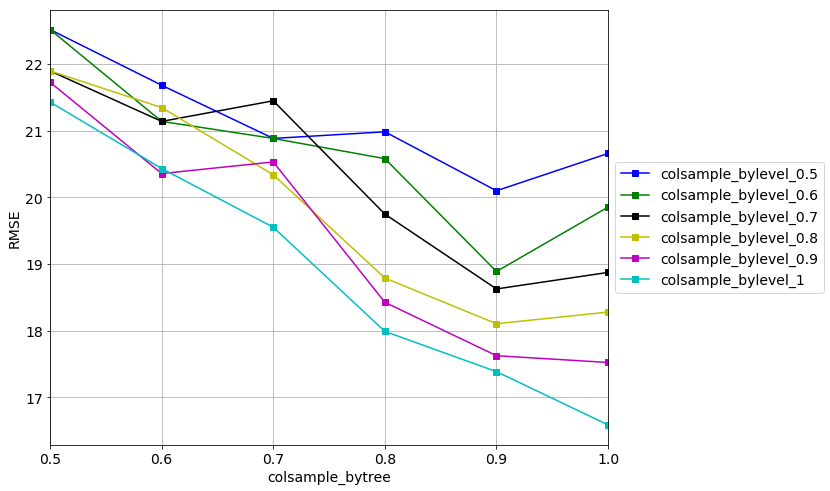

In [69]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [70]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 16.586
optimum params = 


(1.0, 1.0)

In [71]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.048%
optimum params = 


(1.0, 1.0)

# Tuned params

In [72]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,60.000
1,max_depth,3.000,8.000
2,learning_rate,0.100,0.100
3,min_child_weight,1.000,8.000
4,subsample,1.000,0.100
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.500
8,rmse,17.198,16.586
9,mape_pct,1.092,1.048


# FINAL MODEL.

In [73]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt, 
                             max_depth=max_depth_opt, 
                             learning_rate=learning_rate_opt, 
                             min_child_weight=min_child_weight_opt, 
                             subsample=subsample_opt, 
                             colsample_bytree=colsample_bytree_opt, 
                             colsample_bylevel=colsample_bylevel_opt, 
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 33.537
MAPE on test set = 1.235%


Text(0, 0.5, 'USD')

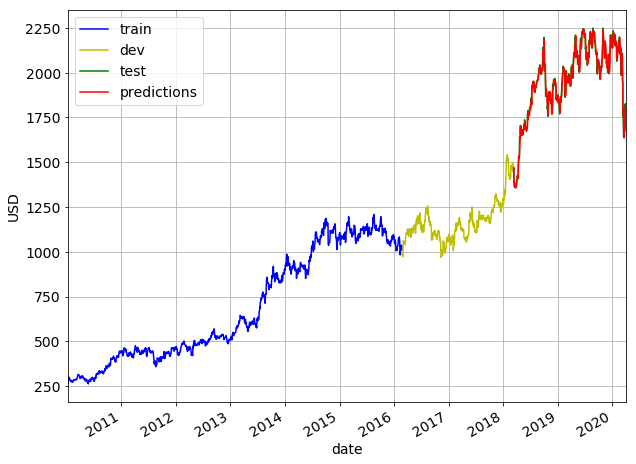

In [74]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

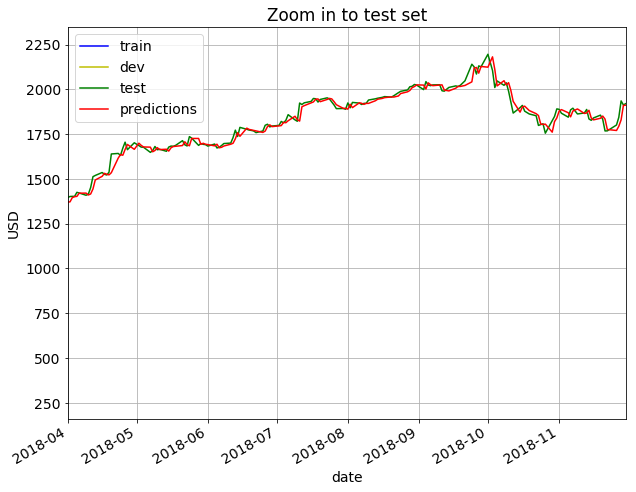

In [75]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 1), date(2018, 11, 30)])
#ax.set_ylim([130, 155])
ax.set_title("Zoom in to test set")

(736807.0, 737021.0)

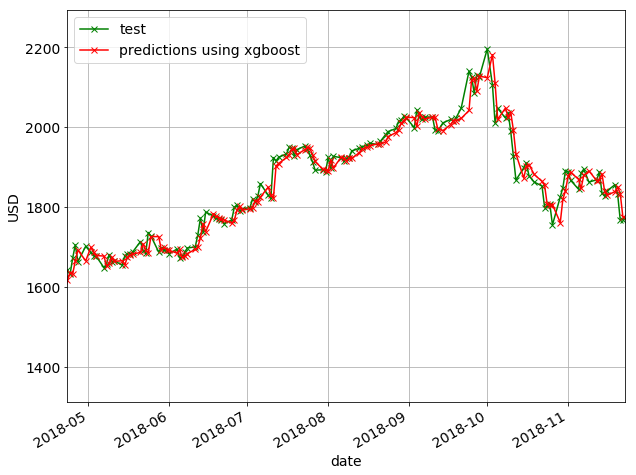

In [76]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
#ax.set_ylim([130, 155])